# Using the Vision Transformer (ViT) Encoder

Using ViT allows you to encode and run decisions based on image data

We start by installing semantic-router with the `[local]` flag to include all necessary dependencies for `VitEncoder`:

In [ ]:
!pip install -qU "semantic-router[local]==0.0.23"

For this example, we will be building functionality to disallow any Shrek pictures from our chatbot.

Let's start by loading some example data for our `utterances`

In [1]:
from datasets import load_dataset

images = load_dataset("aurelio-ai/shrek-detection")
shrek_entries = filter(
    lambda entry: entry["is_shrek"], images["train"]
)  # We only want Shrek images for our route
shrek_images = list(map(lambda entry: entry["image"], shrek_entries))
shrek_images

/Users/bogdanbuduroiu/development/aurelio-labs/semantic-router/.venv/lib/python3.9/site-packages/datasets/load.py:1454: FutureWarning: The repository for aurelio-ai/shrek-detection contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/aurelio-ai/shrek-detection
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=613x527>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=220x191>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=225x225>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=750x1000>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=194x259>]

Let's define our Route that represents images of Shrek

In [2]:
from semantic_router import Route

shrek = Route(name="shrek", utterances=shrek_images)

routes = [shrek]

We are going to use a Visual Transformer (ViT) to encode our images into vector space

For a deeper understanding of Visual Transformers, please refer to: https://arxiv.org/abs/2010.11929

In [3]:
from semantic_router.encoders import VitEncoder

encoder = VitEncoder(
    device="mps"
)  # Using MBP Metal acceleration (for other platforms, please see https://pytorch.org/docs/stable/tensor_attributes.html#torch.device)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


As with other examples, we will go ahead and define a `RouteLayer` which can be used to route between multiple routes.

> ! Note: Since we're only interested in 1 class here (Shrek or not Shrek), we will only have 1 route

> A `RouteChoice(name=None)` here represents that Semantic Router thinks this input is NOT Shrek

In [4]:
from semantic_router.layer import RouteLayer

rl = RouteLayer(encoder=encoder, routes=routes)

2024-02-19 14:40:23 INFO semantic_router.utils.logger local


In [9]:
from io import BytesIO

import requests

from PIL import Image


def load_img(url):
    resp = requests.get(url)
    return Image.open(BytesIO(resp.content))


test_shrek = load_img(
    "https://static.wikia.nocookie.net/dreamworks/images/6/67/Shrek_Profile.jpg/revision/latest/thumbnail/width/360/height/360?cb=20231223041813"
)
test_not_shrek = list(
    map(
        lambda entry: entry["image"],
        filter(lambda entry: not entry["is_shrek"], images["train"]),
    )
)[0]

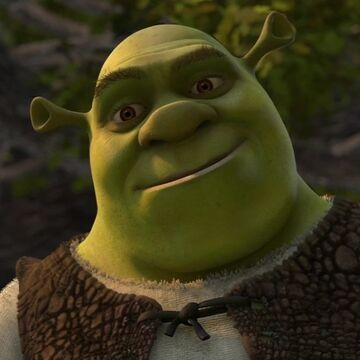

RouteChoice(name='shrek', function_call=None, similarity_score=None, trigger=None)

In [10]:
display(test_shrek)
rl(test_shrek)

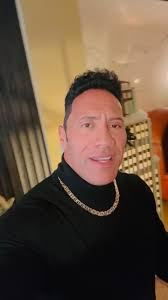

RouteChoice(name=None, function_call=None, similarity_score=None, trigger=None)

In [11]:
display(test_not_shrek)
display(rl(test_not_shrek))